In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb

# Load preprocessed data
df = pd.read_csv('cicids2017_preprocessed_phase1.csv')
X = df.drop('Label', axis=1)
y = df['Label']


### Figure 3.1: Preprocessing Workflow Diagram (Add externally if needed)

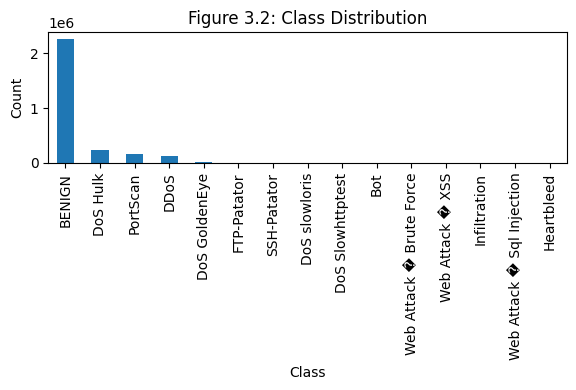

In [4]:

plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar')
plt.title('Figure 3.2: Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


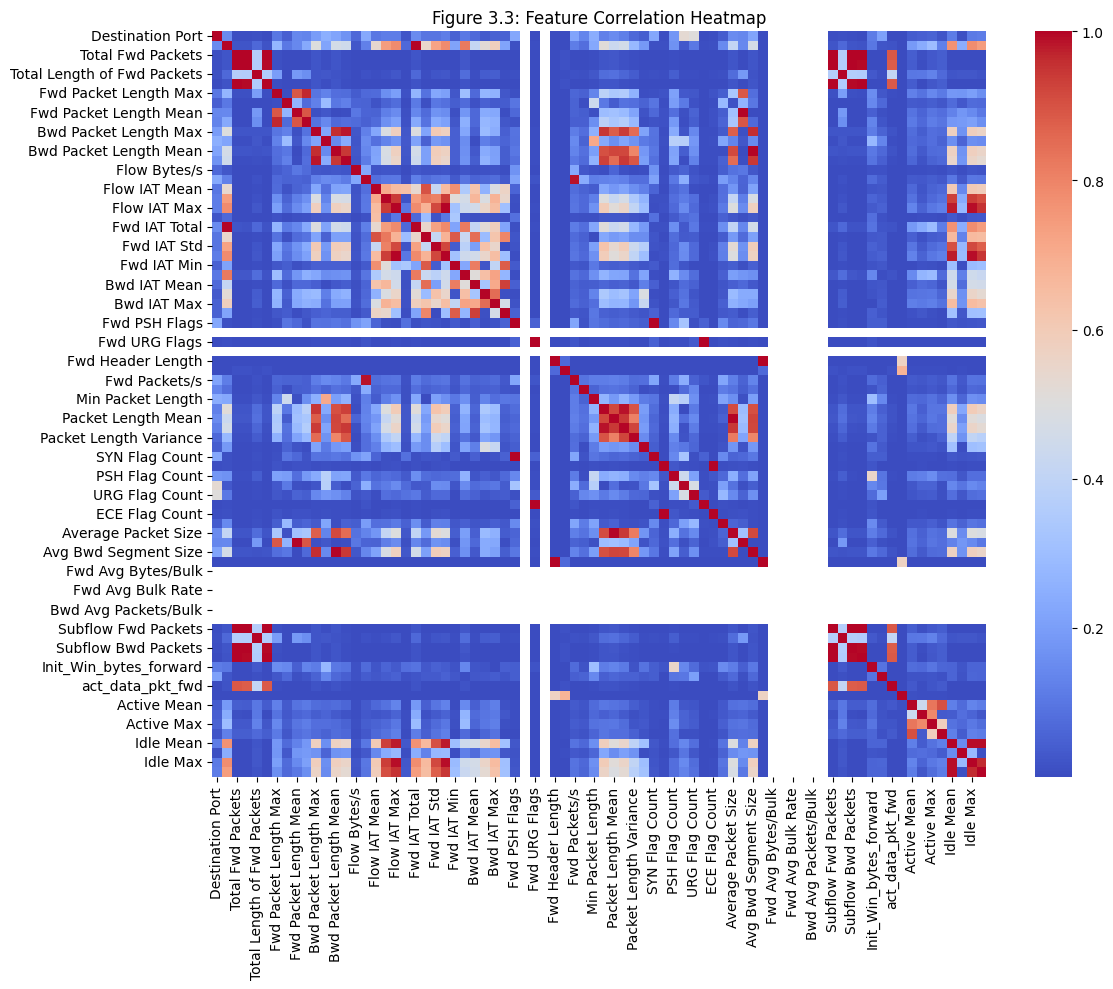

<Figure size 640x480 with 0 Axes>

In [7]:

plt.figure(figsize=(12,10))
sns.heatmap(X.corr().abs(), cmap='coolwarm')
plt.title('Figure 3.3: Feature Correlation Heatmap')
plt.tight_layout()
plt.show()
plt.savefig("my_plot.png", dpi=300, bbox_inches="tight")

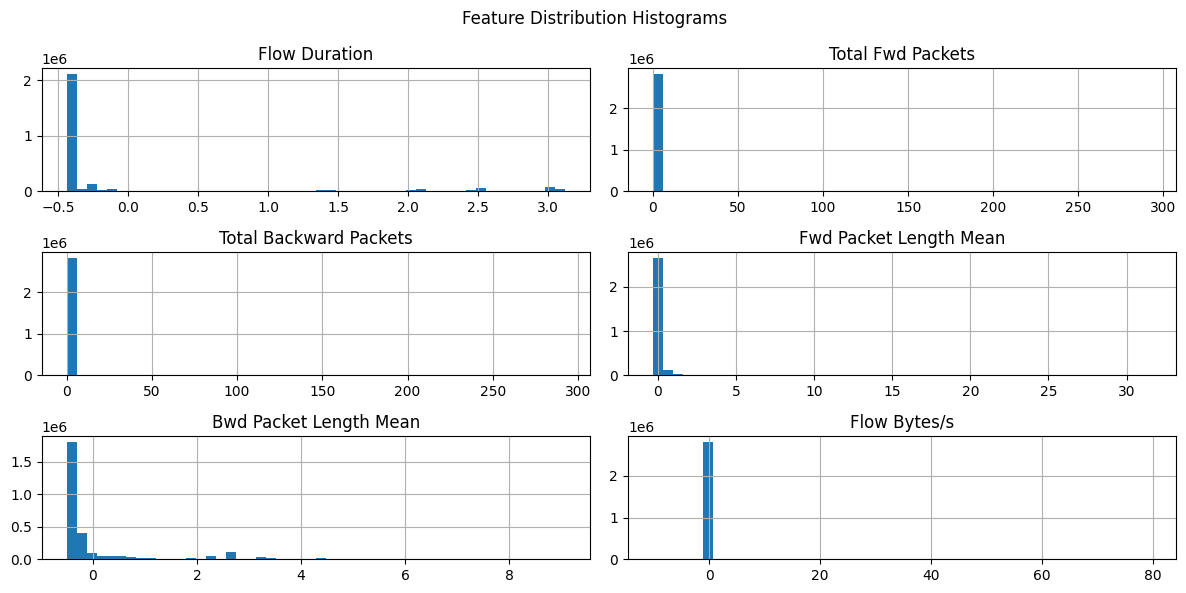

In [6]:

features_to_plot = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
                    'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Flow Bytes/s']
X[features_to_plot].hist(bins=50, figsize=(12, 6))
plt.suptitle("Feature Distribution Histograms")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier

# Sample 10,000 rows for faster processing
X_sample = X.sample(n=3000, random_state=42)
y_sample = y.loc[X_sample.index]

# Fit Random Forest with parallel processing
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_sample, y_sample)

# Compute importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_columns = X_sample.columns[indices[:30]].tolist()

# Plot top 20 importances
plt.figure(figsize=(10,6))
plt.title('Figure 3.4: Random Forest Feature Importances')
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), X_sample.columns[indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Save top 30 features
with open('feature_list.json', 'w') as f:
    json.dump(top_columns, f)



In [15]:

X_selected = X[top_features]
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


### Figure 3.5: Data Splitting Structure (Add flowchart externally if needed)

In [16]:

rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X_train, y_train)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_final, f)


In [18]:
from collections import Counter
print(Counter(y_train))

Counter({'BENIGN': 1589924, 'DoS Hulk': 161087, 'PortScan': 111163, 'DDoS': 89617, 'DoS GoldenEye': 7205, 'FTP-Patator': 5555, 'SSH-Patator': 4128, 'DoS slowloris': 4057, 'DoS Slowhttptest': 3849, 'Bot': 1369, 'Web Attack � Brute Force': 1055, 'Web Attack � XSS': 456, 'Infiltration': 25, 'Web Attack � Sql Injection': 15, 'Heartbleed': 8})


In [19]:
# ---------- 0 | imports & reproducibility -------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing     import LabelEncoder
from sklearn.model_selection   import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics           import classification_report, confusion_matrix
from xgboost                   import XGBClassifier

RANDOM_STATE = 42
GPU_ACCEL    = True        # False if no CUDA GPU

# ---------- 1 | encode labels once --------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
class_names = le.classes_

# ---------- 2 | balanced class-weights ----------------------
classes   = np.unique(y_train_enc)
weights   = compute_class_weight('balanced', classes=classes, y=y_train_enc)
class_wt  = dict(zip(classes, weights))
row_wt    = np.vectorize(class_wt.get)(y_train_enc)   # weight per sample

# ---------- 3 | cast features → float32 (↓ RAM ×2) ----------
X_tr32 = X_train.astype('float32')
X_te32 = X_test.astype('float32')

In [20]:
# ---------- 4 | XGBoost model -------------------------------
xgb = XGBClassifier(
    objective   = 'multi:softprob',
    tree_method = 'hist',
    device = 'cuda',
    eval_metric = 'mlogloss',
    n_estimators= 400,
    subsample   = 0.8,
    random_state= RANDOM_STATE,
    n_jobs      = 1          # single thread keeps memory flat
)

# ---------- 5 | hyper-param search --------------------------
param_dist = {
    'max_depth':        [6, 10, 14],
    'learning_rate':    [0.05, 0.1, 0.2],
    'colsample_bytree': [0.7, 0.9, 1.0],
}

search = RandomizedSearchCV(
    xgb,
    param_dist,
    n_iter      = 6,
    scoring     = 'f1_macro',
    cv          = 3,
    verbose     = 2,
    random_state= RANDOM_STATE
)

In [23]:
# ---------- 6 | fit & evaluate ------------------------------
search.fit(X_tr32, y_train_enc, sample_weight=row_wt)
print("\n⇢ Best params:", search.best_params_)

best_model  = search.best_estimator_
y_pred_enc  = best_model.predict(X_te32)
y_pred      = le.inverse_transform(y_pred_enc)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=class_names))

print("\nConfusion matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   index=class_names, columns=class_names))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\Ronil H Kadia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [10:57:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=14; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=14; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=14; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=6; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=6; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=6; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6; total time= 1.1min
[CV] EN

                            precision    recall  f1-score   support

                    BENIGN     1.0000    0.9988    0.9994    340698
                       Bot     0.6940    0.9829    0.8136       293
                      DDoS     0.9993    0.9996    0.9995     19204
             DoS GoldenEye     0.9828    0.9987    0.9907      1544
                  DoS Hulk     0.9982    0.9992    0.9987     34519
          DoS Slowhttptest     0.9903    0.9927    0.9915       825
             DoS slowloris     0.9908    0.9943    0.9925       870
               FTP-Patator     1.0000    0.9992    0.9996      1190
                Heartbleed     1.0000    1.0000    1.0000         1
              Infiltration     0.8333    1.0000    0.9091         5
                  PortScan     0.9933    0.9996    0.9964     23821
               SSH-Patator     1.0000    1.0000    1.0000       885
  Web Attack � Brute Force     0.6853    0.5973    0.6383       226
Web Attack � Sql Injection     0.6667    0.6667

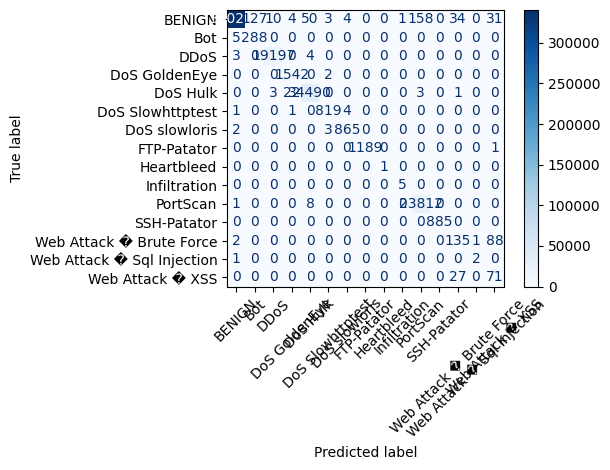

✅ Model and files saved in current directory.


In [24]:
# --- Final test -------------------------------------------------
y_test_pred = search.best_estimator_.predict(X_test)
y_test_pred_str = le.inverse_transform(y_test_pred)      # <- fix

print(classification_report(y_test, y_test_pred_str, digits=4))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred_str,
    xticks_rotation=45,
    cmap='Blues',
    values_format=''           # hides the text overlays
)
plt.tight_layout()
plt.show()
plt.savefig('confusion_matrix_xgb.png')  # Save as image
plt.close()


# --- Save artefacts --------------------------------------------
import joblib, json

joblib.dump(search.best_estimator_, 'best_model.pkl')
with open('feature_list.json', 'w') as f:
    json.dump(X_test.columns.tolist(), f)

print('✅ Model and files saved in current directory.')

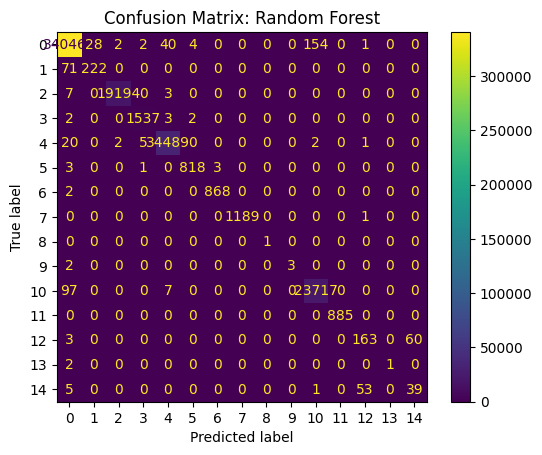

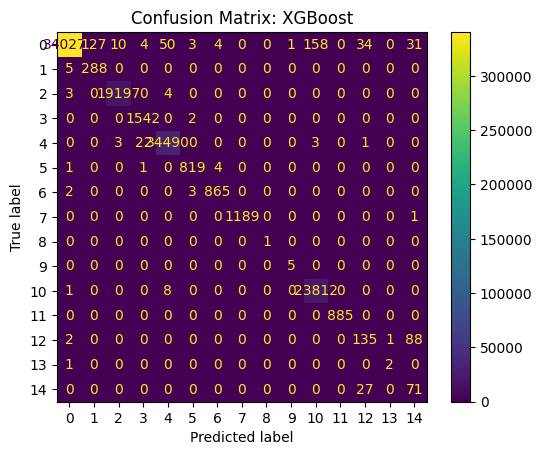

Table 3.2: Precision, Recall, F1-Score Comparison
               precision    recall  f1-score
Random Forest   0.998598  0.998611  0.998599
XGBoost         0.998782  0.998574  0.998645


In [26]:
models = {'Random Forest': rf_final, 'XGBoost': best_model}
metrics_table = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Convert to string labels if XGBoost (since it's using label encoding)
    if name == 'XGBoost':
        y_pred = le.inverse_transform(y_pred)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_table[name] = report['weighted avg']
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

# Create performance table
df_perf = pd.DataFrame(metrics_table).T[['precision', 'recall', 'f1-score']]
print("Table 3.2: Precision, Recall, F1-Score Comparison")
print(df_perf)



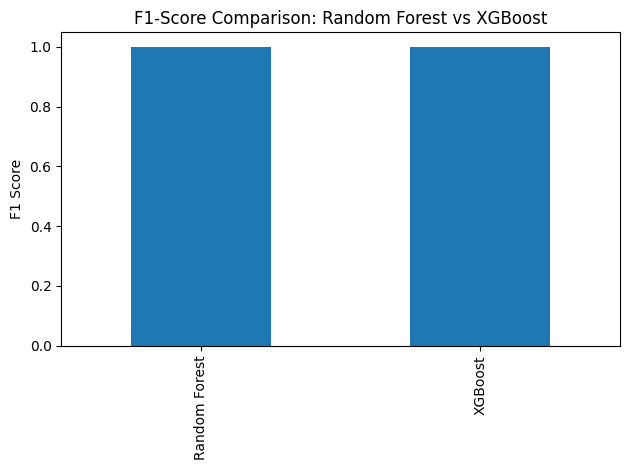

In [27]:

df_perf['f1-score'].plot(kind='bar', title='F1-Score Comparison: Random Forest vs XGBoost')
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()


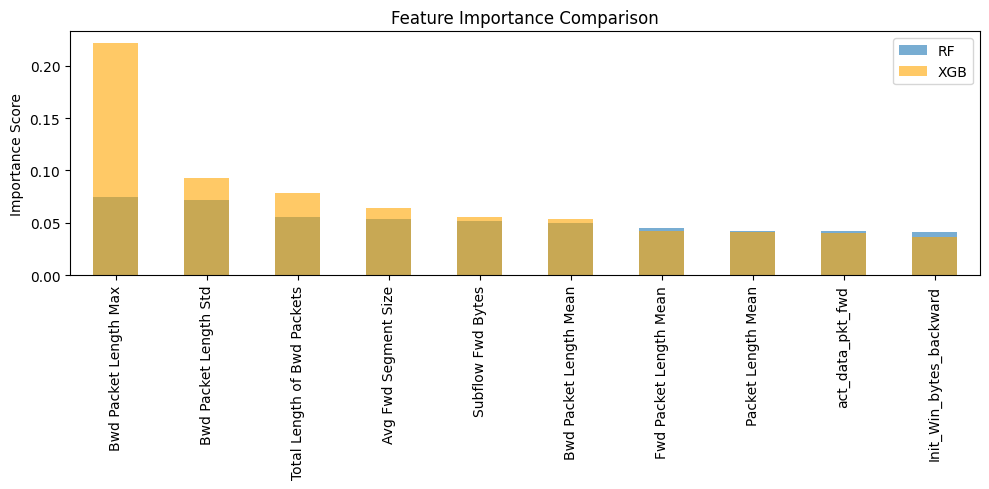

Overlapping Features: ['Subflow Fwd Bytes', 'Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Std']
Unique to RF: ['Destination Port', 'Packet Length Std', 'Packet Length Variance', 'Total Length of Fwd Packets', 'Subflow Bwd Bytes']
Unique to XGB: ['Avg Fwd Segment Size', 'Fwd Packet Length Mean', 'act_data_pkt_fwd', 'Init_Win_bytes_backward', 'Total Length of Bwd Packets']


In [28]:

rf_imp = pd.Series(rf_final.feature_importances_, index=X_selected.columns).sort_values(ascending=False)
xgb_imp = pd.Series(best_model.feature_importances_, index=X_selected.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
rf_imp.head(10).plot(kind='bar', alpha=0.6, label='RF')
xgb_imp.head(10).plot(kind='bar', alpha=0.6, color='orange', label='XGB')
plt.title("Feature Importance Comparison")
plt.ylabel("Importance Score")
plt.legend()
plt.tight_layout()
plt.show()

# Table for overlapping & unique features
overlap = set(rf_imp.head(10).index).intersection(xgb_imp.head(10).index)
unique_rf = set(rf_imp.head(10).index) - overlap
unique_xgb = set(xgb_imp.head(10).index) - overlap

print("Overlapping Features:", list(overlap))
print("Unique to RF:", list(unique_rf))
print("Unique to XGB:", list(unique_xgb))
